# Libraries

In [1]:
! pip install transformers
! pip install hazm
from hazm import *
import copy
import transformers
from sklearn.feature_selection import mutual_info_classif
from transformers import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import json
from copy import deepcopy
import numpy as np
import random
import re
import string
import codecs
from shutil import copyfile
random.seed(12345)
label_encoder = preprocessing.LabelEncoder()

     |████████████████████████████████| 3.5 MB 11.6 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |████████████████████████████████| 895 kB 43.7 MB/s 
     |████████████████████████████████| 596 kB 51.5 MB/s 
     |████████████████████████████████| 6.8 MB 31.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 316 kB 4.4 MB/s 
     |████████████████████████████████| 1.4 MB 37.0 MB/s 
     |████████████████████████████████| 233 kB 28.2 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394488 sha256=4ef183101525f4578a4e7af1c2262c61111e09b91a69396aee3fd70324b061e4
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154499 sha256=2ec3924681ab97821d12bc70db430a6dd9

# Loading & Preprocessing data

Downloading...
From: https://drive.google.com/uc?id=1KpJCXTkuy1NLR5MgXsoYfBsv_OnwJqIF
To: /content/AI_NEWS.csv
100% 16.8M/16.8M [00:00<00:00, 97.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qiq2I8EdTcgn2Wc03XqucUcMhBdVhEre
To: /content/stopwords.txt
100% 3.66k/3.66k [00:00<00:00, 6.41MB/s]


In [3]:
news = pd.read_csv('AI_NEWS.csv')
news

,Unnamed: 0,index,title,text,category,keywords,source_name,data,tag
0,0,2000,لیگ قهرمانان آسیا| استقلال ایران 3 - الشرطه عر...,NaN,ورزشی,لیگ قهرمانان آسیا| استقلال ایران - الشرطه عراق...,جماران,1463620,غیر مهم
1,1,2001,سویه لامبدا؛ خیلی دور، خیلی نزدیک!/ هر آنچه که...,NaN,اقتصادی,NaN,آنا,3041187,غیر مهم
2,2,2002,افزایش تحرکات هیات ها در مذاکرات وین؛ تحولاتی ...,به گزارش خبرنگار ایرنا از وین، آهنگ رفت و آمد ...,بین الملل,"وین,کمیسیون مشترک برجام,علی باقری,مذاکرات برای...",ایرنا,4132788,مهم
3,3,2003,ناکارآمدی بازرگانی محصولات کشاورزی ناشی از ناک...,به گزارش خبرگزاری فارس از تبریز، اکبر فتحی در ...,اقتصادی,"کشاورزی,آذربایجان شرقی,کشاورزان,محصولات,کشت فر...",خبرگزاری فارس,3652101,غیر مهم
4,4,2004,طالبان: بدنبال روابط خوب با همه کشورها از جمله...,به گزارش دفتر منطقه ای خبرگزاری تسنیم، «ذبیح ا...,بین الملل,NaN,خبرگزاری تسنیم,3846298,غیر مهم
...,...,...,...,...,...,...,...,...,...
3995,3995,8972,درگیری شدید شبه نظامیان امارات و عربستان در اس...,به گزارش گروه بین الملل خبرگزاری تسنیم به نقل ...,بین الملل,NaN,خبرگزاری تسنیم,2263257,غیر مهم
3996,3996,8973,امام خمینی (ره) بیش از ایران در جهان موثر بود...,به گزارش خبرنگار خبرگزاری شبستان از شیراز، اند...,فرهنگ و هنر,NaN,شبستان,1967520,غیر مهم
3997,3997,8974,مادری که رهبر انقلاب برایش دعا کردند کیست؟/ قر...,گروه خانواده؛ نعیمه موحد: دیدار دانشجویی امسال...,فرهنگ و هنر,"حضرت آیت الله خامنه ای,جنبش دانشجویی,خبر خوب,...",خبرگزاری فارس,1748716,غیر مهم
3998,3998,8975,\t\t \t\t\tلحظه دلهره آور نجات سگی که در یخبن...,به گزارش خبرنگار حوزه اخبار داغ گروه فضای مجاز...,فناوری و ارتباطات,نجات سگ \t\t\t\t\t، \t\t\...,باشگاه خبرنگاران,61151,غیر مهم


In [4]:
class Preprocessing:

  @staticmethod
  def remove_punctuations(text):
    new_text = []
    for l in text:
      if l not in string.punctuation + '\u00AB' + '\u00BB' + '\u060C' + '\u061B' + '\u061F':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)
  
  @staticmethod
  def remove_numbers(text):
    new_text = []
    for l in text:
      if l not in '0123456789۰۱۲۳۴۵۶۷۸۹':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)

  @staticmethod
  def remove_stopwords(text):
    normalizer = Normalizer()
    stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('stopwords.txt','r','utf-8').readlines()]
    tokens = word_tokenize(text)
    new_text = []
    for token in tokens:
      if token not in stopwords:
        new_text.append(token)
      else:
        new_text.append(' ')
    return ' '.join(new_text)

  @staticmethod
  def remove_extra_space(text):
    new_text = re.sub(r'\s+',' ',text)
    return new_text

In [5]:
# a class to hold our data structure
class Data:
  def __init__(self, data, preprocessing=False):
    self.title = data['title']
    self.text = data['text']
    self.category = data['category']
    self.label = label_encoder.transform([data['tag']])[0]

# label encoder
all_labels = ['مهم','غیر مهم']
label_encoder.fit(all_labels)
classes = label_encoder.classes_

# convert raw data into Data objects
news_data = []
for index, data in news.iterrows():
  news_data.append(Data(data, True))

In [6]:
def split_data(data, portions=[.6,.2,.2]):
  random.shuffle(data)
  data_len = len(data)
  train_data = data[:int(portions[0] * data_len)]
  eval_data = data[int(portions[0] * data_len):int((portions[0] + portions[1]) * data_len)]
  test_data = data[int((portions[0] + portions[1]) * data_len):]
  return train_data, eval_data, test_data

In [7]:
# a function to get a portion of data with acquired preprocessings
def get_data(dataset, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True}):
  random.shuffle(dataset)
  new_dataset = []

  # applying preprocessings on train data
  for i, data in enumerate(tqdm(dataset)):
    if str(data.text) == 'nan':
      continue
    if preprocess['remove_stopwords'] == True:
      dataset[i].text = Preprocessing.remove_stopwords(data.text)
    if preprocess['remove_punctuations'] == True:
      dataset[i].text = Preprocessing.remove_punctuations(data.text)
    if preprocess['remove_numbers'] == True:
      dataset[i].text = Preprocessing.remove_numbers(data.text)
    dataset[i].text = Preprocessing.remove_extra_space(data.text)
    new_dataset.append(dataset[i])

  return split_data(new_dataset)

# Roberta

In [8]:
train_data, eval_data, test_data = get_data(news_data, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True})

100%|██████████| 4000/4000 [01:19<00:00, 50.05it/s]


In [9]:
eval_data[10].title

'اتمام بازسازی بقعه احمدابن اسحاق(ره) تا پایان سال جاری/ ۱۶ میلیارد تومان تاکنون هزینه شده است'

## Load Roberta

In [10]:
# loading pars roberta and tokenizer
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel
# v3.0
model_name_or_path = "HooshvareLab/roberta-fa-zwnj-base"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
# model = TFAutoModel.from_pretrained(model_name_or_path)  For TF
parsbert = AutoModel.from_pretrained(model_name_or_path)

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/302 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/855k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/315 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/roberta-fa-zwnj-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at HooshvareLab/roberta-fa-zwnj-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stre

## Transformer Dataloader

In [11]:
# a class for loading data
class NewsDataloader(Dataset):

  def __init__(self,dataset,tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    text_tokens = self.tokenizer.encode_plus(
        str(self.dataset[idx].title),
        str(self.dataset[idx].text),
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_tensors="pt",
        truncation=True
    )

    return [text_tokens, self.dataset[idx].label]

In [12]:
# defining our transformer model
class TransformerModel(nn.Module):

  def __init__(self, roberta):
    super(TransformerModel, self).__init__()
    self.roberta = roberta
    # we only use one linear head on the parsbert
    self.linear_head = nn.Linear(768, len(label_encoder.classes_))

  def forward(self, x):
    # main task
    x = self.roberta(x['input_ids'],x['attention_mask'])
    logits = self.linear_head(x.pooler_output)
    return logits

## Training Transformer

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Transformer Training
epochs = 4
lr = 8e-6
device = 'cuda:0'
k_step_loss = 0
k = 50
batch_size = 11
# get train dataloader
train_dataset = NewsDataloader(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# get train dataloader
eval_dataset = NewsDataloader(eval_data, tokenizer)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)
# get eval dataloader
num_steps = int(np.ceil(len(train_dataloader.dataset) / batch_size))
loss_collection = []
eval_f1_micro = []
eval_f1_macro = []
eval_accuracy = []
best_model = None
best_f1_macro = 0
model = TransformerModel(parsbert).to(device)
loss_fn = nn.CrossEntropyLoss(torch.tensor([.25, 1])).to(device)
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, 
    num_training_steps=epochs * len(train_dataloader.dataset)
)


for epoch in range(epochs):
  for step, data in enumerate(train_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    optimizer.zero_grad()
    output = model(feed_dict)
    loss = loss_fn(output, labels)
    # loss scheduler
    loss.backward()
    optimizer.step()
    scheduler.step()
    k_step_loss += loss.item()
    if (step + 1) % k == 0:
      loss_collection.append(k_step_loss)
      print(f'EPOCH {epoch + 1}/{epochs} | STEP [{step + 1}/{num_steps}] | Loss {k_step_loss}')
      k_step_loss = 0

  k_step_loss = 0
  print(f'################## Epoch {epoch + 1} Evaluation ##################')
  with torch.no_grad():
    all_pred = []
    all_label = []
    for j, data in enumerate(eval_dataloader):
      input_ids = data[0]["input_ids"].squeeze().to(device)
      attention_mask = data[0]["attention_mask"].squeeze().to(device)
      labels = data[1].to(device)
      feed_dict = {
          'input_ids': input_ids,
          'attention_mask': attention_mask
      }
      output = model(feed_dict)
      pred = output.argmax(dim=1, keepdim=True)
      all_label.extend(list(labels.cpu().numpy()))
      all_pred.extend(list(pred.view(-1).cpu().numpy()))


    f1_macro = f1_score(all_label, all_pred, average='macro')
    f1_micro = f1_score(all_label, all_pred, average='micro')
    accuracy = accuracy_score(all_label, all_pred)
    recall = recall_score(all_label, all_pred)
    roc_auc = roc_auc_score(all_label, all_pred)
    precision = precision_score(all_label, all_pred)

    if f1_macro > best_f1_macro:
      best_f1_macro = f1_macro
      best_model = copy.deepcopy(model)

    print(f'ROC-AUC {roc_auc}')
    print(f'F1-macro {f1_macro}')
    print(f'F1-micro {f1_micro}')
    print(f'Accuracy {accuracy}')
    print(f'Recall {recall}')
    print(f'Precision {precision}')
    eval_f1_macro.append(f1_macro)
    eval_f1_micro.append(f1_micro)
    eval_accuracy.append(accuracy)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 1/4 | STEP [50/207] | Loss 31.882750272750854
EPOCH 1/4 | STEP [100/207] | Loss 29.335344552993774
EPOCH 1/4 | STEP [150/207] | Loss 29.104451209306717
EPOCH 1/4 | STEP [200/207] | Loss 28.772381514310837
################## Epoch 1 Evaluation ##################
ROC-AUC 0.6773744292237444
F1-macro 0.6417079110938367
F1-micro 0.8005284015852048
Accuracy 0.8005284015852048
Recall 0.51
Precision 0.3333333333333333


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 2/4 | STEP [50/207] | Loss 23.052597120404243
EPOCH 2/4 | STEP [100/207] | Loss 24.593494325876236
EPOCH 2/4 | STEP [150/207] | Loss 22.081334486603737
EPOCH 2/4 | STEP [200/207] | Loss 22.18050143122673
################## Epoch 2 Evaluation ##################
ROC-AUC 0.6497640791476408
F1-macro 0.6157301296743528
F1-micro 0.7820343461030383
Accuracy 0.7820343461030383
Recall 0.47
Precision 0.29559748427672955


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 3/4 | STEP [50/207] | Loss 15.22296667844057
EPOCH 3/4 | STEP [100/207] | Loss 18.777544036507607
EPOCH 3/4 | STEP [150/207] | Loss 16.460809785872698
EPOCH 3/4 | STEP [200/207] | Loss 14.922276712954044
################## Epoch 3 Evaluation ##################
ROC-AUC 0.6754185692541858
F1-macro 0.6431610864801509
F1-micro 0.8044914134742405
Accuracy 0.8044914134742405
Recall 0.5
Precision 0.33783783783783783


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 4/4 | STEP [50/207] | Loss 7.109070613980293
EPOCH 4/4 | STEP [100/207] | Loss 7.776552611030638
EPOCH 4/4 | STEP [150/207] | Loss 6.586655371822417
EPOCH 4/4 | STEP [200/207] | Loss 6.888843146618456
################## Epoch 4 Evaluation ##################
ROC-AUC 0.5798858447488584
F1-macro 0.5951871657754011
F1-micro 0.8520475561426684
Accuracy 0.8520475561426685
Recall 0.21
Precision 0.3888888888888889


Text(0, 0.5, 'f1-macro')

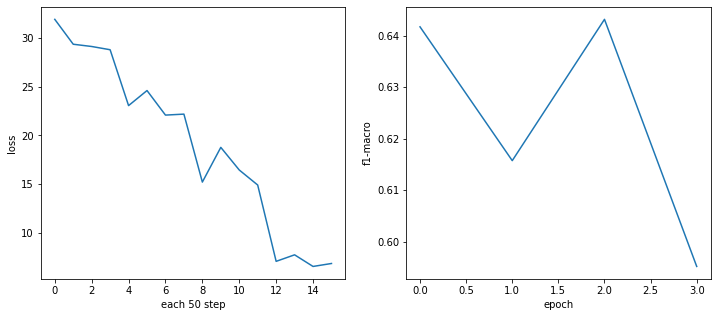

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(range(len(loss_collection)), loss_collection)
plt.xlabel(f'each {k} step')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(range(len(eval_f1_macro)), eval_f1_macro)
plt.xlabel(f'epoch')
plt.ylabel('f1-macro')

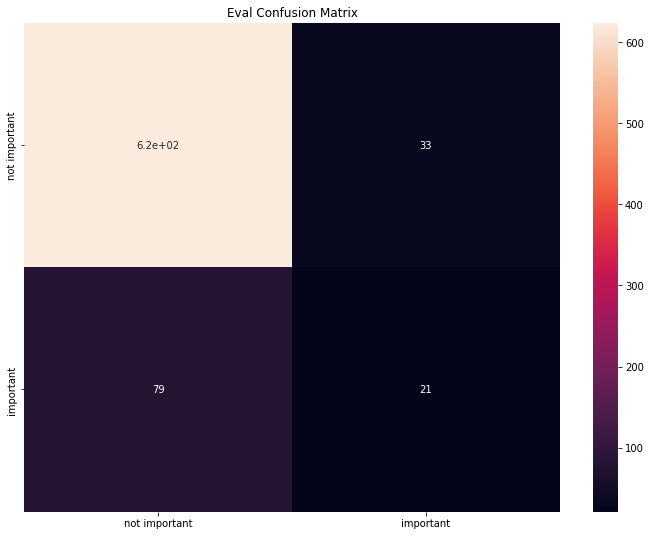

In [ ]:
# confusion matrix for test data
classes = ['not important', 'important']
c_mat = confusion_matrix(all_label, all_pred)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,9))
plt.title('Eval Confusion Matrix')
sn.heatmap(df_cm, annot=True)
plt.savefig('roberta_conf.jpg', dpi=400)

## Tesing

In [ ]:
# save model
from google.colab import drive  
drive.mount('/content/drive')
torch.save(best_model, 'drive/MyDrive/project_roberta_final_.pth')

## Load Trained Model

In [14]:
! pip install -U --no-cache-dir gdown --pre

In [16]:
# load colab
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
model = torch.load('drive/MyDrive/project_roberta_final_.pth')

In [ ]:
model = torch.load('project_roberta_final_.pth')

In [19]:
# test dataloader
device = 'cuda:0'
test_dataset = NewsDataloader(test_data, tokenizer)
batch_size = 11
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model = model.to(device)

with torch.no_grad():
  all_pred = []
  all_label = []
  all_output = []
  for j, data in enumerate(test_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }
    output = model(feed_dict)
    pred = output.argmax(dim=1, keepdim=True)
    all_label.extend(list(labels.cpu().numpy()))
    all_pred.extend(list(pred.view(-1).cpu().numpy()))
    all_output.extend(list(torch.max(torch.sigmoid(output), dim=1).values.cpu().numpy()))

  f1_macro = f1_score(all_label, all_pred, average='macro')
  f1_micro = f1_score(all_label, all_pred, average='micro')
  accuracy = accuracy_score(all_label, all_pred)
  recall = recall_score(all_label, all_pred)
  roc_auc = roc_auc_score(all_label, all_pred)
  precision = precision_score(all_label, all_pred)

  print(f'ROC-AUC {roc_auc}')
  print(f'F1-macro {f1_macro}')
  print(f'F1-micro {f1_micro}')
  print(f'Accuracy {accuracy}')
  print(f'Recall {recall}')
  print(f'Precision {precision}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


ROC-AUC 0.6853128460686602
F1-macro 0.6435889962558572
F1-micro 0.7780713342140027
Accuracy 0.7780713342140027
Recall 0.5535714285714286
Precision 0.34444444444444444


## Test Confusion Matrix

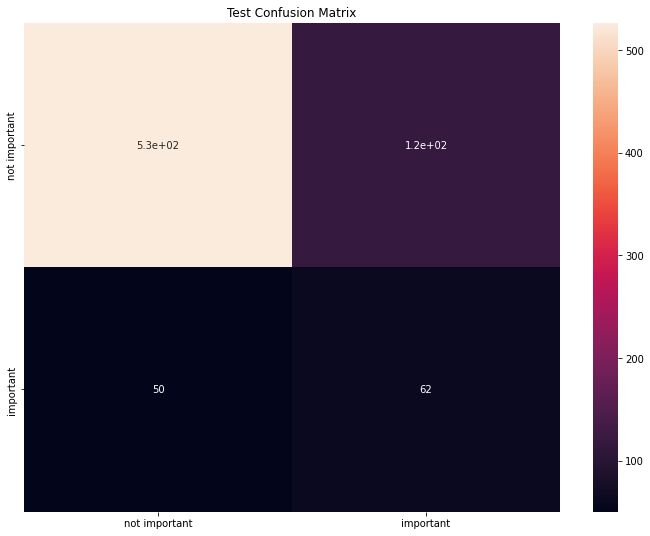

In [20]:
# confusion matrix for test data
classes = ['not important', 'important']
c_mat = confusion_matrix(all_label, all_pred)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,9))
plt.title('Test Confusion Matrix')
sn.heatmap(df_cm, annot=True)
plt.savefig('roberta_conf.jpg', dpi=400)

## Save Predictions

In [ ]:
import pickle

with open('roberta_prob', 'wb') as f:
  pickle.dump(all_output, f)

with open('roberta_pred', 'wb') as f:
  pickle.dump(all_pred, f)

## Extract *Keywords*

In [22]:
# we use mutual information to extract keywords
device = 'cuda:0'
batch_size = 11
# get train dataloader
train_dataset = NewsDataloader(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
model = model.to(device)
feature_matrix = np.zeros(shape=(len(train_data), len(tokenizer)))
all_pred = []
current_index = 0

# compute feature matrix and predictions using training data
with torch.no_grad():
  for step, data in enumerate(train_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }
    output = model(feed_dict)
    pred = output.argmax(dim=1, keepdim=True)
    all_pred.extend(list(pred.view(-1).cpu().numpy()))

    for i in range(input_ids.shape[0]):
      for id in data[0]['input_ids'][i]:
        feature_matrix[current_index, id] = 1
      current_index += 1

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Important News Keywords

In [44]:
# extracting 40 tokens with high mutual information with important data
# get vocab of tokenizer
vocab = np.array([tokenizer.decode(i) for i in range(len(tokenizer))])
all_pred = np.array(all_pred)
# calculate mutual information
tokens_mutual_infomation = mutual_info_classif(feature_matrix, all_pred)
# get indicies of 40 most important keywords
max_ind = np.argpartition(tokens_mutual_infomation, -40)[-40:]
tokens_mutual_infomation[max_ind]
for i in zip(vocab[max_ind], tokens_mutual_infomation[max_ind]):
  print(i)

(' تمایلی', 0.026857626524902756)
(' ریلکس', 0.026946033823686433)
(' لابی', 0.02710694842803396)
('زبانه', 0.027850745707358904)
(' صرافی', 0.02830167646036852)
('کریس', 0.02748162277821975)
('فکر', 0.027262430045943198)
(' رهنورد', 0.02811200028148786)
(' یهود', 0.02865137406680507)
(' کسر', 0.02715795591264758)
(' بپرهیزید', 0.028168105824208922)
(' مناظری', 0.027499112149240945)
('وپاتی', 0.02791745213786756)
(' لارنس', 0.028564986371280243)
(' فحش', 0.027396756352601415)
(' ویت', 0.028390117493986233)
(' جوید', 0.02769914886078828)
(' حلیم', 0.028546214779351597)
(' هخامنشی', 0.028756668642294647)
('b', 0.029025569642145532)
('chart', 0.030962146370082433)
(' اختیارتان', 0.030069965087503148)
('بته', 0.02931130029732487)
(' کوجیما', 0.02913316623218165)
(' مارش', 0.02880508646949198)
(' ترویج', 0.029003703361570654)
('حساب', 0.030074425659835757)
(' لطف', 0.0299403362727384)
(' جوانب', 0.0304519749398533)
('اریوم', 0.02942515381675448)
(' رندوم', 0.031019451281345756)
(' Lenovo', 

### Not-Important News Keywords

In [45]:
# extracting 40 tokens with high mutual information with non-important data
all_pred_not = np.where((all_pred==0)|(all_pred==1), all_pred^1, all_pred)
# calculate mutual information
tokens_mutual_infomation = mutual_info_classif(feature_matrix, all_pred_not)
# get indicies of 40 most important keywords
max_ind = np.argpartition(tokens_mutual_infomation, -40)[-40:]
tokens_mutual_infomation[max_ind]
for i in zip(vocab[max_ind], tokens_mutual_infomation[max_ind]):
  print(i)

(' حنفی', 0.026250738243382088)
(' باقیم', 0.02706729912392758)
(' ازلحاظ', 0.02673050648383901)
(' جادوگری', 0.027018043632219158)
('uel', 0.027606222265781355)
(' شکسته', 0.027066850279600985)
('استیون', 0.028444070068159633)
(' باربر', 0.027049394225613144)
(' تراک', 0.02648436982560165)
(' استیصال', 0.02741041703054381)
('ight', 0.02814076747479266)
(' نیجریه', 0.027072297749678675)
(' وسیله', 0.027209425261396802)
(' برو', 0.0275377827823704)
(' سیروس', 0.027026747715776622)
('پوشه', 0.027320303422406544)
(' لوبیای', 0.02731604513639585)
(' بستری', 0.027403846953560462)
(' درود', 0.02825394744851817)
(' چگ', 0.02650189137496861)
(' ماراتن', 0.028606389073085436)
('place', 0.030954880293062148)
('AND', 0.028931891708887658)
(' میزان', 0.030813286853133226)
(' روایی', 0.0310639277040623)
(' زرد', 0.029059050414706133)
('شخصی', 0.029410773213123464)
(' سریانی', 0.0314211251295895)
('پاری', 0.032227744249300194)
('anced', 0.030541549053923367)
(' CMOS', 0.02896573414618997)
(' بلوتوثی

# Load & Use Model

In [ ]:
! gdown --id 1-0LNvBpZ92jf1tlxSFMV_6iaQ1BPWbIh
best_model = torch.load('project_roberta_final_.pth')